In [294]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Setup
Imports, paths, and global config.

In [295]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [296]:
from pathlib import Path
PROJECT_ROOT = Path("/content/drive/MyDrive/projects/satellite-property-valuation")
DATA_DIR = PROJECT_ROOT / "data"
RAW_DIR = DATA_DIR / "raw"
PROC_DIR = DATA_DIR / "processed"

IMG_DIR = RAW_DIR / "images"

OUT_DIR = PROJECT_ROOT / "outputs"
EMB_DIR = OUT_DIR / "embeddings"
MODEL_DIR = OUT_DIR / "models"


# Tabular Data

In [297]:
df = pd.read_csv(PROC_DIR / "train_tabular_processed.csv")
df.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,long,sqft_living15,sqft_lot15,year,month,day,day_of_week,is_renovated,building_age,log_price
0,9117000170,268643,4,2.25,1810,9240,2.0,0,0,3,...,-122.187,1660,9240,2015,5,5,1,0,54,12.501139
1,6700390210,245000,3,2.50,1600,2788,2.0,0,0,4,...,-122.187,1720,3605,2014,7,8,1,0,22,12.409013
2,7212660540,200000,4,2.50,1720,8638,2.0,0,0,3,...,-122.313,1870,7455,2015,1,15,3,0,21,12.206073
3,8562780200,352499,2,2.25,1240,705,2.0,0,0,3,...,-122.073,1240,750,2015,4,27,0,0,6,12.772803
4,7760400350,232000,3,2.00,1280,13356,1.0,0,0,3,...,-122.074,1590,8071,2014,12,5,4,0,20,12.354493


In [298]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16209 entries, 0 to 16208
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             16209 non-null  int64  
 1   price          16209 non-null  int64  
 2   bedrooms       16209 non-null  int64  
 3   bathrooms      16209 non-null  float64
 4   sqft_living    16209 non-null  int64  
 5   sqft_lot       16209 non-null  int64  
 6   floors         16209 non-null  float64
 7   waterfront     16209 non-null  int64  
 8   view           16209 non-null  int64  
 9   condition      16209 non-null  int64  
 10  grade          16209 non-null  int64  
 11  sqft_above     16209 non-null  int64  
 12  sqft_basement  16209 non-null  int64  
 13  lat            16209 non-null  float64
 14  long           16209 non-null  float64
 15  sqft_living15  16209 non-null  int64  
 16  sqft_lot15     16209 non-null  int64  
 17  year           16209 non-null  int64  
 18  month 

Split into train / validation.

In [299]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["price", "log_price", "id"])    #id doesn't carry any real meaning. Hence removed them.
y = df["log_price"]

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)


In [300]:
from sklearn.metrics import root_mean_squared_error, r2_score

def eval_log_space(y_true_log, y_pred_log):
    return {
            "R2": r2_score(y_true_log, y_pred_log),
            "RMSE": root_mean_squared_error(y_true_log, y_pred_log)
        }

def eval_price_space(y_true_log, y_pred_log):
    y_true = np.exp(y_true_log)
    y_pred = np.exp(y_pred_log)
    return {
        "R2": r2_score(y_true, y_pred),
        "RMSE": root_mean_squared_error(y_true, y_pred)
    }


## Linear Regression Baseline
Train a simple linear regression model as a weak reference baseline.
Kept simple on purpose.

In [301]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_val)

print(eval_log_space(y_val, y_pred_lr))


{'R2': 0.7769127258889715, 'RMSE': 0.2481169736779706}


## Random Forest Model
Train a Random Forest regressor to capture non-linear feature interactions.


In [302]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_val)

print(eval_log_space(y_val, y_pred_rf))


{'R2': 0.8839778871228012, 'RMSE': 0.17893259564908523}


### Prediction vs Actual
Visualize predicted prices against true prices to inspect fit quality.


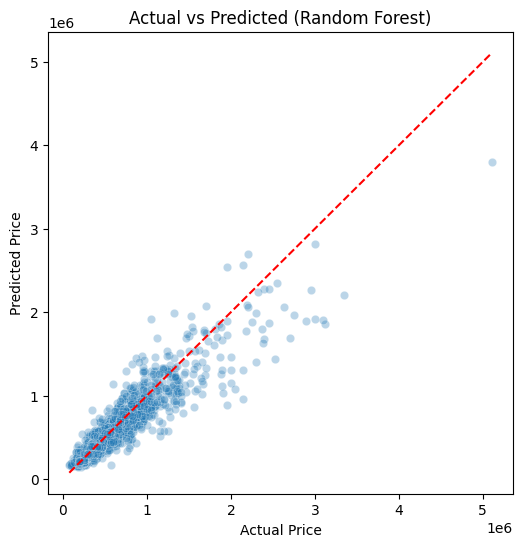

In [303]:
y_val_price = np.exp(y_val)
y_pred_price = np.exp(y_pred_rf)

plt.figure(figsize=(6,6))
sns.scatterplot(x=y_val_price, y=y_pred_price, alpha=0.3)
plt.plot(
    [y_val_price.min(), y_val_price.max()],
    [y_val_price.min(), y_val_price.max()],
    linestyle="--",
    color="red",
)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted (Random Forest)")
plt.show()


### Residual Analysis
Analyze residual distribution to understand error spread and bias.


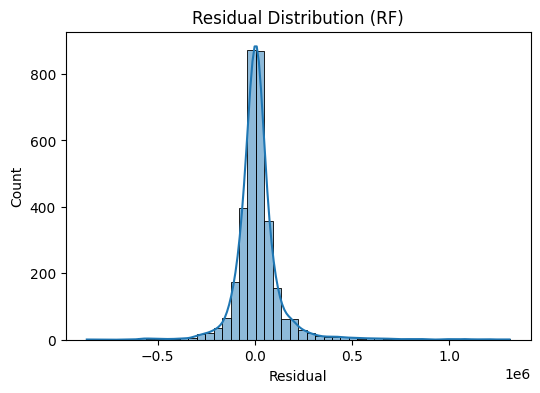

In [304]:
residuals = y_val_price - y_pred_price

plt.figure(figsize=(6,4))
sns.histplot(residuals, bins=50, kde=True)
plt.title("Residual Distribution (RF)")
plt.xlabel("Residual")
plt.show()


### Feature Importance
Identify the most influential tabular features using Random Forest importance scores.


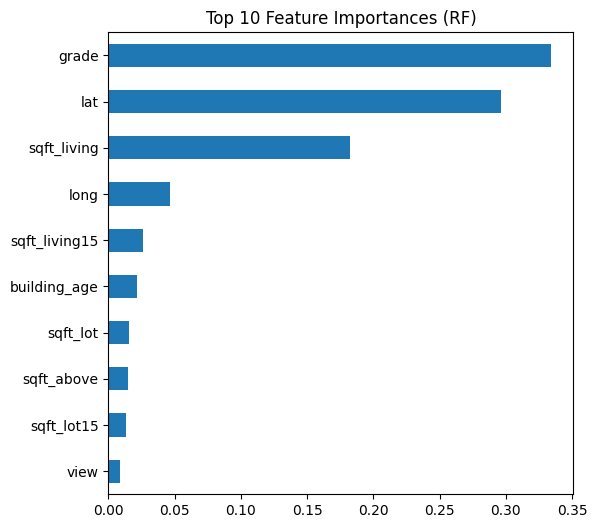

In [305]:
importances = pd.Series(
    rf.feature_importances_,
    index=X.columns,
).sort_values(ascending=False)

plt.figure(figsize=(6,6))
importances.head(10).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances (RF)")
plt.show()


### XGBoost Model
Train a gradient-boosted tree model as a stronger tabular baseline.


In [306]:
# -----------------------------
# XGBoost Model
# -----------------------------
from xgboost import XGBRegressor


model = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
)

model.fit(X_train, y_train)

y_pred_rf = rf.predict(X_val)

print(eval_log_space(y_val, y_pred_rf))



{'R2': 0.8839778871228012, 'RMSE': 0.17893259564908523}


---

# Tabular + Image Data

In [307]:
# -----------------------------
# Load tabular data
# -----------------------------
df_tab_train = pd.read_csv(
    DATA_DIR / "processed/train_tabular_processed.csv",
)

df_tab_test = pd.read_csv(
    DATA_DIR / "processed/test_tabular_processed.csv",
)

### Tabular Features
Separate the log-transformed target variable and tabular input features.


In [308]:
# Targets
y_train_log = df_tab_train["log_price"].values

# Tabular features
tabular_cols = df_tab_train.drop(
    columns=["price", "log_price", "id"],
    errors="ignore"
).columns

X_tab_train = df_tab_train[tabular_cols].values
X_tab_test  = df_tab_test[tabular_cols].values


### Image Embeddings
Load frozen CNN-based image embeddings indexed by property ID.


In [309]:
# -----------------------------
# Load image embeddings
# -----------------------------
img_embeddings = np.load(EMB_DIR / "image_embeddings.npy")
img_ids        = np.load(EMB_DIR / "image_ids.npy")
assert len(img_embeddings) == len(img_ids)

df_img_emb = pd.DataFrame(
    img_embeddings,
    index=img_ids
)
assert df_img_emb.index.is_unique


Align image embeddings with tabular rows using property id.


In [310]:
# Align embeddings with tabular rows
train_ids = df_tab_train["id"].values       #as images are keyed by "id", which may be repeated
test_ids  = df_tab_test["id"].values

X_img_train = df_img_emb.loc[train_ids].values
X_img_test  = df_img_emb.loc[test_ids].values

assert X_img_train.shape[0] == X_tab_train.shape[0]

### PCA
On image embeddings

In [311]:
from sklearn.decomposition import PCA

pca = PCA(n_components=64, random_state=42)

X_img_train_pca = pca.fit_transform(X_img_train)
X_img_test_pca  = pca.transform(X_img_test)

print("Image PCA shape:", X_img_train_pca.shape)


Image PCA shape: (16209, 64)


Concatenate tabular features and image embeddings into a single feature vector.

In [312]:
# -----------------------------
# Multimodal feature matrix
# -----------------------------
# X_mm_train = np.hstack([X_tab_train, X_img_train])
X_mm_train_pca = np.hstack([X_tab_train, X_img_train_pca])
X_mm_test_pca  = np.hstack([X_tab_test,  X_img_test_pca])


In [313]:
# -----------------------------
# Train / validation split
# -----------------------------
from sklearn.preprocessing import StandardScaler


X_tr, X_val, y_tr_log, y_val_log = train_test_split(
    X_mm_train_pca,
    y_train_log,
    test_size=0.2,
    random_state=42,
)

### Feature Scaling
Standardize only the image embedding portion using training split statistics.

In [314]:
#Scale embeddings properly
tab_dim = X_tab_train.shape[1]
#---------------------------
scaler = StandardScaler()
X_tr[:, tab_dim:]  = scaler.fit_transform(X_tr[:, tab_dim:])
X_val[:, tab_dim:] = scaler.transform(X_val[:, tab_dim:])
#---------------------------
X_mm_test_pca[:, tab_dim:] = scaler.transform(X_mm_test_pca[:, tab_dim:])

## Multimodal Model
Train an XGBoost regressor on combined tabular and image features.


### Hyperparamter Tuning

In [360]:
!pip install scikit-optimize -q

In [316]:
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from sklearn.model_selection import KFold
from xgboost import XGBRegressor

# Define the search space for hyperparameters
space  = [
    Integer(200, 400, name='n_estimators'),
    Integer(3, 10, name='max_depth'),
    Real(0.03, 0.08, name='learning_rate'),
    Real(0.7, 0.9, name='subsample'),
    Real(0.7, 0.9, name='colsample_bytree'),
    Real(1e-9, 10.0, 'log-uniform', name='reg_alpha'),
    Real(1e-9, 10.0, 'log-uniform', name='reg_lambda')
]

# Define the objective function
@use_named_args(space)
def objective(n_estimators, max_depth, learning_rate, subsample, colsample_bytree, reg_alpha, reg_lambda):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = []

    for train_index, val_index in kf.split(X_tr):
        X_train_fold, X_val_fold = X_tr[train_index], X_tr[val_index]
        y_train_fold, y_val_fold = y_tr_log[train_index], y_tr_log[val_index]

        model_tuned = XGBRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            random_state=42,
            tree_method="hist",
            device="cuda",
            n_jobs=-1
        )
        model_tuned.fit(X_train_fold, y_train_fold)
        y_pred_fold = model_tuned.predict(X_val_fold)
        rmse = root_mean_squared_error(y_val_fold, y_pred_fold)
        rmse_scores.append(rmse)

    # Skopt minimizes the objective, so we return the negative RMSE
    return np.mean(rmse_scores)

print("Objective function defined and search space created.")

Objective function defined and search space created.


In [317]:
result = gp_minimize(
    func=objective,
    dimensions=space,
    n_calls=40,  # Number of iterations for optimization
    n_initial_points=10, # Number of random points to sample initially
    acq_func='gp_hedge', # Acquisition function
    random_state=42,
    verbose=True,
)

print("Bayesian optimization complete.")
print("Best score (RMSE):", result.fun)
print("Best hyperparameters:", dict(zip([dim.name for dim in space], result.x)))

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 6.3498
Function value obtained: 0.1728
Current minimum: 0.1728
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 7.1332
Function value obtained: 0.1748
Current minimum: 0.1728
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 17.1947
Function value obtained: 0.1727
Current minimum: 0.1727
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 18.4234
Function value obtained: 0.1758
Current minimum: 0.1727
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 12.2290
Function value obtained: 0.1746
Current minimum: 0.1727
Iteration No: 6 started. Evaluat

#### Model Training

In [318]:
best_params = dict(zip([dim.name for dim in space], result.x))

optimized_model = XGBRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda'],
    random_state=42,
    tree_method="hist",
    device="cuda",
    n_jobs=-1
)

optimized_model.fit(X_tr, y_tr_log)

print("Optimized XGBoost model trained with best hyperparameters.")

Optimized XGBoost model trained with best hyperparameters.


#### Model Evaluation

In [319]:
y_val_pred_optimized = optimized_model.predict(X_val)

print("Optimized Model Validation metrics:", eval_log_space(y_val_log, y_val_pred_optimized))

Optimized Model Validation metrics: {'R2': 0.8972351793922546, 'RMSE': 0.16839969909201127}


### Evaluation on Test Data and Submission

In [320]:

y_pred_log_optimized = optimized_model.predict(X_mm_test_pca)
y_pred_optimized = np.exp(y_pred_log_optimized)

submission_df_optimized = pd.DataFrame({
    "id": df_tab_test["id"].values,
    "predicted_price": y_pred_optimized
})
assert len(submission_df_optimized) == len(df_tab_test)
assert submission_df_optimized.columns.tolist() == ["id", "predicted_price"]

submission_path_optimized = PROJECT_ROOT / "23117149_final.csv"
submission_df_optimized.to_csv(submission_path_optimized, index=False)

print(f"Saved optimized submission to: {submission_path_optimized}")

Saved optimized submission to: /content/drive/MyDrive/projects/satellite-property-valuation/23117149_final.csv


## Image-Only Baseline
Estimate standalone predictive signal from satellite images using PCA and Random Forest.


In [339]:
from sklearn.decomposition import PCA
from xgboost import XGBRegressor

pca = PCA(n_components=32, random_state=42)
X_img_train_pca = pca.fit_transform(X_tr[:, tab_dim:])
X_img_val_pca   = pca.transform(X_val[:, tab_dim:])



xgb_img = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist",
    random_state=42,
)

xgb_img.fit(X_img_train_pca, y_tr_log)
y_val_img = xgb_img.predict(X_img_val_pca)


print(eval_log_space(y_val_log, y_val_img))


{'R2': 0.1400325841260882, 'RMSE': 0.48714704780352786}


## ---------------------------------------------

## Explainability
Using Grad-Cam

In [347]:
!pip install grad-cam -q

In [348]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torchvision import models, transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image


In [349]:
# -----------------------------
# Load CNN
import torch
from torchvision import models

device = "cuda" if torch.cuda.is_available() else "cpu"

weights = models.EfficientNet_B0_Weights.DEFAULT
cnn = models.efficientnet_b0(weights=weights)

# remove classification head
cnn.classifier = torch.nn.Identity()

cnn.eval()
cnn.to(device)
target_layer = cnn.features[-1]



In [350]:
# -----------------------------
# Image transform (same as embeddings)
# -----------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225],
    ),
])


In [351]:

# -----------------------------
# Pick ONE image by index (no hardcoding)
# -----------------------------
image_dir = DATA_DIR / "images"
image_files = sorted([
    p for p in image_dir.iterdir()
    if p.suffix.lower() in {".jpg", ".jpeg", ".png"}
])

idx = 5   # change index if you want a different image
img_path = image_files[idx]

img = Image.open(img_path).convert("RGB")

In [352]:
# -----------------------------
# Prepare inputs
# -----------------------------
# CNN input (normalized)
image_tensor = transform(img).to(device)

# Visualization image (unnormalized)
rgb_image = np.array(img.resize((224, 224))) / 255.0

In [353]:
# -----------------------------
# Grad-CAM
# -----------------------------
cam = GradCAM(
    model=cnn,
    target_layers=[target_layer],
)

grayscale_cam = cam(
    input_tensor=image_tensor.unsqueeze(0)
)[0]

cam_image = show_cam_on_image(
    rgb_image,
    grayscale_cam,
    use_rgb=True
)


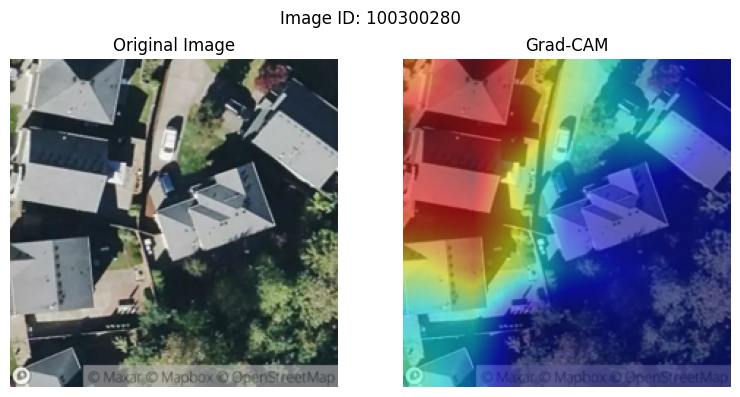

In [354]:
# -----------------------------
# Plot original + Grad-CAM
# -----------------------------
plt.figure(figsize=(8,4))

plt.subplot(1, 2, 1)
plt.imshow(rgb_image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cam_image)
plt.title("Grad-CAM")
plt.axis("off")

plt.suptitle(f"Image ID: {img_path.stem}")
plt.tight_layout()
plt.show()

## Visual Explainability (Grad-CAM)

Grad-CAM is applied to the pretrained CNN used for satellite image feature extraction,
independently of the downstream regression model.

Due to computational constraints, Grad-CAM visualizations are shown for a small subset
of representative satellite images. The highlighted regions correspond to roads,
vegetation, and dense built-up areas, indicating that the CNN focuses on neighborhood
structure and environmental context.
